In [11]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pyloudnorm as pyln
# https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
from scipy.signal import savgol_filter

from data.dataset import MultitrackAudioDataset
from data.dataset_utils import load_tracks, load_tracks_musdb18
from data.songlists import medleydb_independent, musdb18_test
from models.model_scalar_1s import MixingModelScalar1s
from models.model_scalar_2s import MixingModelScalar2s
from models.baselines.mean_loudness_model import MeanLoudnessModel
from inference_utils import mix_song_smooth
from evaluation import LoudnessEvaluator

%load_ext autoreload
%autoreload 2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Torch version:  1.6.0
Device:  cuda


In [18]:
base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MUSDB18HQ/test/'
song_name = 'BKS - Bulldozer'

loaded_tracks = load_tracks_musdb18(base_dir, song_name, tracklist=('bass', 'drums', 'vocals', 'other'))

tracks = ['bass', 'drums', 'vocals', 'other']
coeffs = [1.0, 1.0, 1.0, 1.0]

sum_track = np.zeros_like(loaded_tracks['drums'])
for i, track in enumerate(tracks):
    sum_track += coeffs[i] * loaded_tracks[track]

sum_track = librosa.util.normalize(sum_track, axis=1)
sf.write('./results/{}_sum_raw.wav'.format('BKS - Bulldozer'), sum_track.T, 44100)

In [4]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
chunk_length = 1

d = MultitrackAudioDataset(
    base_path,
    songlist=[],
    chunk_length=chunk_length,
    normalize=False,
    compute_features=False,
    augment_data=False
)

In [5]:
model = MixingModelScalar1s().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

908400 trainable parameters


In [6]:
# weights = './weights/final/mixmodel_scalar2d_1s_0040_72.3425.pt'
# weights = './saved_models/24-08-2020-21:57_training_4masks_unnorm_1s_Vermont/scalar1s_14_neg_train_loss=-927.6083.pt'
weights = './saved_models/from_server/21-08-2020-10:49_training_4masks_unnorm_1s_medleydb+musdb_train_30_epochs_110_val_loss/scalar1s_23_neg_train_loss=-109.7035.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

### Mix all songs from a songlist

In [10]:
base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio/'
songlist = medleydb_independent
load_tracks = load_tracks

# base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MUSDB18HQ/test/'
# songlist = musdb18_test
# load_tracks = load_tracks_musdb18


for i, song_name in enumerate(songlist):
    print('{}/{}: {}'.format(i + 1, len(songlist), song_name))
    loaded_tracks = load_tracks(base_dir, song_name)
#     loaded_tracks = load_tracks_musdb18(base_dir, song_name)

    mixed_tracks, raw_gains, smooth_gains = mix_song_smooth(d, model, loaded_tracks, chunk_length=chunk_length)
    track_arr = np.array(list(mixed_tracks.values()))
    track_sum = np.sum(track_arr, axis=0)
    mixed_tracks['mix'] = librosa.util.normalize(track_sum, axis=1)
    sf.write('./results/{}_mixed.wav'.format(song_name), mixed_tracks['mix'].T, 44100)

    # producing a sum track for comparison
    tracks = ['bass', 'drums', 'vocals', 'other']
    coeffs = [1.0, 1.0, 1.0, 1.0]

    sum_track = np.zeros_like(loaded_tracks['mix'])
    for i, track in enumerate(tracks):
        sum_track += coeffs[i] * loaded_tracks[track]

    sum_track = librosa.util.normalize(sum_track, axis=1)
    sf.write('./results/{}_sum.wav'.format(song_name), sum_track.T, 44100)

1/30: AimeeNorwich_Child
2/30: AimeeNorwich_Flying
3/30: AlexanderRoss_GoodbyeBolero
4/30: AlexanderRoss_VelvetCurtain
5/30: AmarLal_Rest
6/30: AmarLal_SpringDay1
7/30: MatthewEntwistle_AnEveningWithOliver
8/30: MatthewEntwistle_DontYouEver
9/30: MatthewEntwistle_FairerHopes
10/30: MatthewEntwistle_ImpressionsOfSaturn
11/30: MatthewEntwistle_Lontano
12/30: MatthewEntwistle_TheArch
13/30: MatthewEntwistle_TheFlaxenField
14/30: Meaxic_TakeAStep
15/30: Meaxic_YouListen
16/30: ClaraBerryAndWooldog_WaltzForMyVictims
17/30: CroqueMadame_Oil
18/30: CroqueMadame_Pilot
19/30: EthanHein_1930sSynthAndUprightBass
20/30: EthanHein_BluesForNofi
21/30: EthanHein_GirlOnABridge
22/30: EthanHein_HarmonicaFigure
23/30: TheScarletBrand_LesFleursDuMal
24/30: ClaraBerryAndWooldog_AirTraffic
25/30: ClaraBerryAndWooldog_Boys
26/30: ClaraBerryAndWooldog_Stella
27/30: ClaraBerryAndWooldog_TheBadGuys
28/30: JoelHelander_Definition
29/30: JoelHelander_ExcessiveResistancetoChange
30/30: JoelHelander_IntheAtticBedr

---
### Mix a single song

In [12]:
# loaded_tracks = load_tracks(base_dir, song_name)
loaded_tracks = load_tracks_musdb18(base_dir, song_name)

# random_gains = np.random.uniform(0.1, 2.5, size=4)
# print(random_gains)

# for i, track in enumerate(loaded_tracks):
#     if track != 'mix':
#         loaded_tracks[track] = random_gains[i] * loaded_tracks[track]

mixed_tracks, raw_gains, smooth_gains = mix_song_smooth(d, model, loaded_tracks, chunk_length=chunk_length)
track_arr = np.array(list(mixed_tracks.values()))
track_sum = np.sum(track_arr, axis=0)
# mixed_tracks['mix'] = track_sum
mixed_tracks['mix'] = librosa.util.normalize(track_sum, axis=1)
sf.write('./results/{}_mixed.wav'.format(song_name), mixed_tracks['mix'].T, 44100)

### Producing a sum track for comparison

In [9]:
tracks = ['bass', 'drums', 'vocals', 'other']
coeffs = [1.0, 1.0, 1.0, 1.0]

sum_track = np.zeros_like(loaded_tracks['mix'])
for i, track in enumerate(tracks):
    sum_track += coeffs[i] * loaded_tracks[track]

sum_track = librosa.util.normalize(sum_track, axis=1)
sf.write('./results/{}_sum.wav'.format(song_name), sum_track.T, 44100)

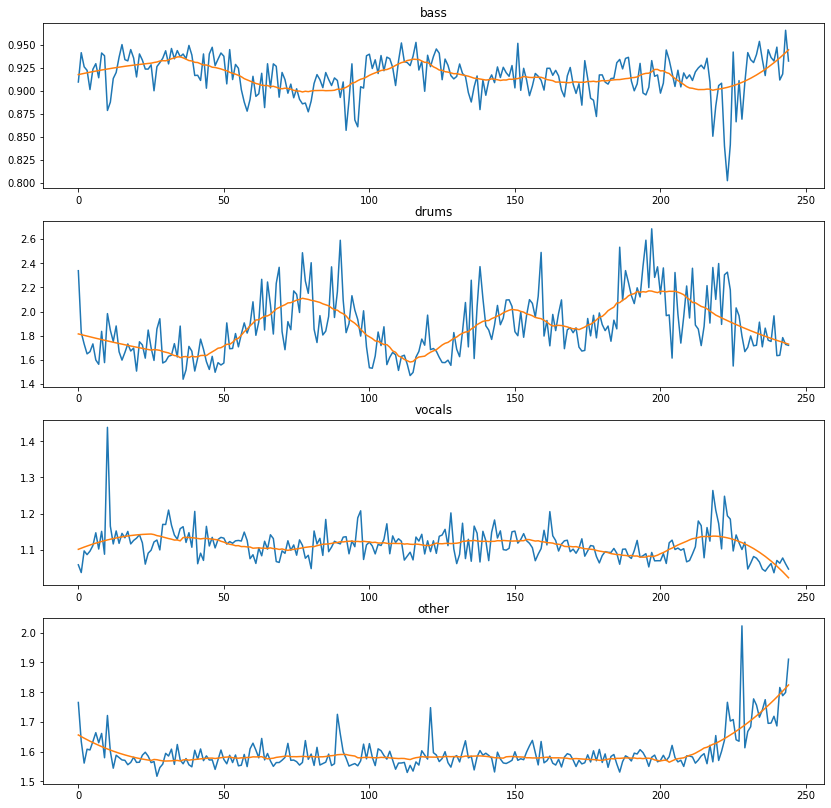

In [10]:
plt.figure(figsize=(14, 14))

for i, track in enumerate(raw_gains):
    plt.subplot(4, 1, i + 1)
    plt.title(track)

    x_vals = range(len(raw_gains['bass']))
    plt.plot(x_vals, raw_gains[track])
    plt.plot(x_vals, smooth_gains[track])

In [21]:
loudnorm_model = MeanLoudnessModel(mean_loudness)

In [23]:
loudnorm_tracks = loudnorm_model.forward(loaded_tracks)
track_arr = np.array(list(loudnorm_tracks.values()))
track_sum = np.sum(track_arr, axis=0)
loudnorm_tracks['mix'] = librosa.util.normalize(track_sum, axis=1)

# mix = librosa.util.normalize(mixed_tracks['mix'], axis=1)
mix = loudnorm_tracks['mix']

sf.write('./results/{}_loudnorm.wav'.format(song_name), mix.T, 44100)

In [28]:
def evaluate_loudness(tracks: dict) -> list:
    assert 'mix' in tracks, 'Mix has to be in track dict for evaluation'

    per_track_loudness = []
    meter = pyln.Meter(44100)

    mix_loudness = meter.integrated_loudness(tracks['mix'].T)

    for track_name in ('bass', 'drums', 'vocals', 'other'):
        track_loudness = meter.integrated_loudness(tracks[track_name].T)
        print('{} loudness: {:.5f}'.format(track_name.upper(), track_loudness))
        per_track_loudness.append(track_loudness / mix_loudness)

    return per_track_loudness

In [29]:
mix_loudness = evaluate_loudness(mixed_tracks)
loudnorm_loudness = evaluate_loudness(loudnorm_tracks)

BASS loudness: -21.43770
DRUMS loudness: -20.04222
VOCALS loudness: -22.69484
OTHER loudness: -17.09298
BASS loudness: -27.08582
DRUMS loudness: -30.14345
VOCALS loudness: -28.37598
OTHER loudness: -26.53397


In [30]:
print(mix_loudness)

[1.3723627557799036, 1.2830295135989813, 1.4528404671761364, 1.0942298178783154]


In [31]:
print(loudnorm_loudness)

[1.8553368065258167, 2.0647799464344154, 1.9437105739974334, 1.8175359291577164]
